# Un'analisi IRT dei quesiti del Bebras italiano

L'*Item Response Theory* (IRT) è una tecnica statistica che si propone di stimare l'*abilità* dei soggetti cui viene sottoposto un test composto da una serie di domande (dette *item*). L'abilità è un tratto *latente*, cioè non osservabile direttamente: l'aver risposto correttamente a molte domande può dipendere sia da elevata abilità, che dalla "facilità" delle domande. La stima si basa quindi su un *modello matematico* (detto *Item Response Function*) della relazione fra abilità e probabilità di rispondere correttamente alla domanda.

Il modello usato in questa analisi è un curva *logistica*, la cui forma è regolata da tre parametri $a, b, c$.
$$ p_i(\theta_j) = c_i + \frac{(1 - c_i)}{1+ e^{-b_i\cdot(\theta_j - a_i)}} $$
La probabilità $p$ di successo in un *item* $i$ è funzione dell'abilità $\theta$ del solutore $j$. I tre parametri modellano le caratteristiche dell'*item*:
- $a$, detto *difficoltà* dell'item: determina il livello di abilità necessaria per avere il 50% di probabilità di successo;
- $b$, detto *differenziazione*: determina quanto influiscono le variazioni di abilità sulla probabilità di successo;
- $c$: fissa una probabilità minima di successo per qualsiasi abilità, dovuta per esempio alla possibilità di scegliere casualmente la risposta giusta ($c$ sarà 0 per un *item* a risposta completamente aperta)

In [1]:
library("ggplot2")

In [28]:
data <- NULL;
data$x <- seq(-5, 5, .1);
data$y <- 1 / (1 + exp(-data$x));
data <- as.data.frame(data);


In [29]:
p<- ggplot(data, aes(x=x)) + scale_x_continuous() + geom_line(aes(y=y))

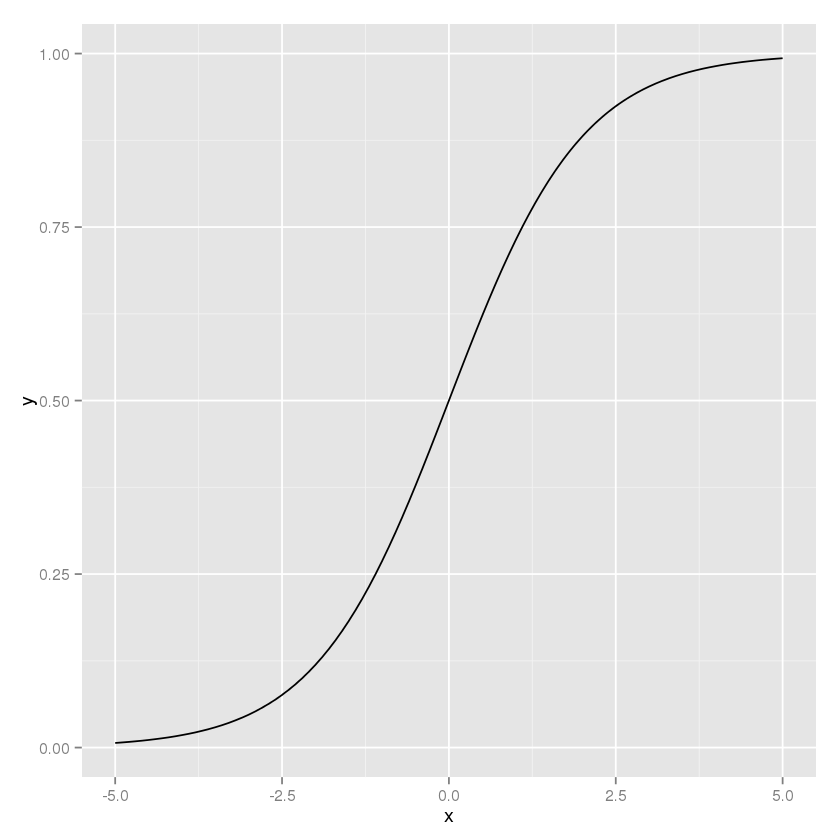

In [30]:
p